# Objective

1. Create a frame classification pipeline based on players that are n yard apart
2. Use their helmet bounding boxes to crop out the part of the frame the contains both of them
2. Run a frame classification pipeline on these images

# Steps

1. Fitler data for close players based on distance threshold
2. Crop a specific frame between two players based on bboxes and visualize
3. Create fastai pipeline

# Configuration

In [1]:
class CFG:
    seed = 4121995
    undersample_no_contact = True
    img_size = 224
    model = 'resnet18'  
    epochs = 1
    train = True
    valid = True
    infer = True
    thresh = 0.3
    dist_thresh = 1
    model_name = 'model-1.pkl'

In [2]:
LS = !ls
IS_KAGGLE = 'init.sh' not in LS
IS_KAGGLE

False

# Load libraries

In [3]:
import sys

if IS_KAGGLE:
    sys.path.append('/kaggle/input/timm-0-6-9/pytorch-image-models-master')
    CFG.frames_path = ''
    CFG.utils_path = '/kaggle/input/nflutils'
    
    sys.path.insert(0, '../input/nflutils')
    !mkdir -p nflutils
    !cp ../input/nflutils/*.py nflutils/
    
else:
    CFG.frames_path = 'frames/content/work/frames/train'
    CFG.utils_path = 'nflutils'

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import pickle
import timm

from pathlib import Path

from nflutils.dataprep import *

from tqdm.notebook import tqdm

from sklearn.metrics import matthews_corrcoef

# Read Files

In [5]:
if IS_KAGGLE:
    BASE_DIR = Path("../input/nfl-player-contact-detection")
    OUT_DIR = Path("/kaggle/working/")
else:
    BASE_DIR = Path("nfl-player-contact-detection")
    OUT_DIR = Path("nfl-player-contact-detection/frames")

In [6]:
ss = pd.read_csv(BASE_DIR/"sample_submission.csv")

# Player tracking data
te_tracking = pd.read_csv(
    BASE_DIR/"test_player_tracking.csv", parse_dates=["datetime"]
)

# Baseline helmet detection labels
te_helmets = pd.read_csv(BASE_DIR/"test_baseline_helmets.csv")

In [7]:
if CFG.train or CFG.valid:
    df_combo = pd.read_parquet('df_combo.parquet')
    df_combo_with_helmets = pd.read_parquet('df_combo_with_helmets.parquet')

# Train

In [8]:
from fastai.vision.all import *

import cv2

In [9]:
labels = pd.read_csv(f"{BASE_DIR}/train_labels.csv", parse_dates=["datetime"])

tr_tracking = pd.read_csv(
    BASE_DIR/"train_player_tracking.csv", parse_dates=["datetime"]
)

In [10]:
tr_helmets = pd.read_csv(BASE_DIR/"train_baseline_helmets.csv")

In [82]:
df_combo = compute_distance(labels, tr_tracking)

In [95]:
df_combo.query('distance < 2').shape

(249908, 12)

<AxesSubplot:>

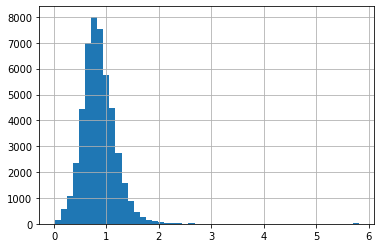

In [98]:
df_combo.query('contact == 1').distance.hist(bins=50)

In [70]:
df_combo.query('contact == 1').distance.max()

5.8148946680056035

In [71]:
df_combo = df_combo.query('distance > 5 and contact == 1')

game_plays = np.random.choice(df_combo.game_play.unique(), size=10)

In [72]:
game_plays

array(['58224_002486', '58336_000203', '58224_002486', '58224_002486',
       '58224_002486', '58336_000203', '58336_000203', '58336_000203',
       '58336_000203', '58224_002486'], dtype=object)

In [73]:
df_combo = df_combo.query('game_play in @game_plays')

df_tracking_helmets = pd.DataFrame()

for gp in tqdm(df_combo.game_play.unique()):
    df_tracking_helmets = pd.concat([df_tracking_helmets,
                                     merge_tracking_and_helmets(df_combo.query('game_play == @gp'), 
                                                                tr_helmets.query('game_play == @gp'))])
    
df_tracking_helmets = calc_two_players_helmets_center(df_tracking_helmets)

df_tracking_helmets = df_tracking_helmets[df_tracking_helmets.left_1.notnull()]
df_tracking_helmets = df_tracking_helmets[df_tracking_helmets.left_2.notnull()]

  0%|          | 0/2 [00:00<?, ?it/s]

In [74]:
if CFG.train:
    kf_dict = pickle.load(open('kf_dict', 'rb'))
    frames_df = get_frames_df(df_tracking_helmets, kf_dict, split=0, frames_path=CFG.frames_path, undersample_no_contact=False, sample_every_n_frame=2, sample_train=None, sample_val=0.07)

In [75]:
frames_df= frames_df.query('contact == 1')

In [76]:
frames_df.loc[frames_df.index[0], 'is_valid'] = False

In [79]:
frames_df.head()

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,x_position_1,y_position_1,x_position_2,...,top_2,height_2,top,left,bottom,right,center_y,center_x,is_valid,path
13,58224_002486_40_35485_46107,58224_002486,2020-10-04 19:03:48.300000+00:00,40,35485,46107,1,42.96,16.38,41.67,...,364.0,15.0,364.0,406.0,422.0,440.0,393.0,423.0,False,frames/content/work/frames/train/58224_002486_Sideline.mp4_0530.jpg
14,58224_002486_40_35485_46107,58224_002486,2020-10-04 19:03:48.300000+00:00,40,35485,46107,1,42.96,16.38,41.67,...,372.0,15.0,366.0,675.0,397.0,759.0,381.0,717.0,False,frames/content/work/frames/train/58224_002486_Endzone.mp4_0530.jpg
25,58224_002486_41_35485_46107,58224_002486,2020-10-04 19:03:48.400000+00:00,41,35485,46107,1,42.97,16.23,41.65,...,406.0,16.0,406.0,424.0,427.0,521.0,416.0,472.0,False,frames/content/work/frames/train/58224_002486_Sideline.mp4_0536.jpg
26,58224_002486_41_35485_46107,58224_002486,2020-10-04 19:03:48.400000+00:00,41,35485,46107,1,42.97,16.23,41.65,...,375.0,16.0,367.0,681.0,398.0,756.0,382.0,718.0,False,frames/content/work/frames/train/58224_002486_Endzone.mp4_0536.jpg
37,58224_002486_42_35485_46107,58224_002486,2020-10-04 19:03:48.500000+00:00,42,35485,46107,1,42.95,16.14,41.65,...,406.0,16.0,406.0,428.0,430.0,525.0,418.0,476.0,False,frames/content/work/frames/train/58224_002486_Sideline.mp4_0542.jpg


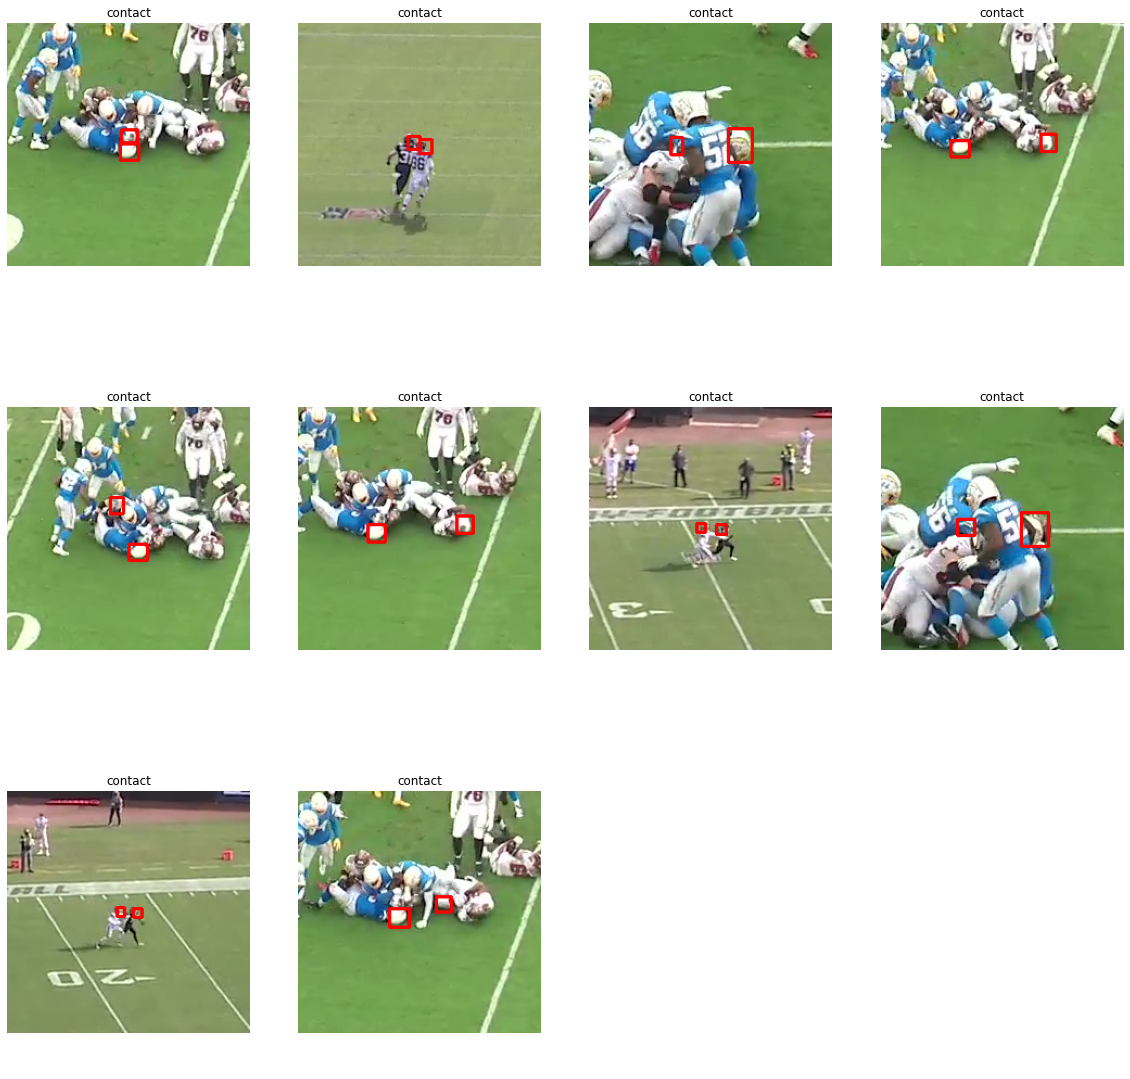

In [81]:
if CFG.train:
    dls = get_dls(frames_df, bs=64, img_size=224)
    dls.show_batch(max_n=64, figsize=(20, 20))

In [11]:
if CFG.train:
    learn = get_learner('efficientnet_b0', dls).to_fp16()
    # valley = learn.lr_find()

In [ ]:
if CFG.train:
    learn.fine_tune(5, 1e-4)
    learn.export('nflutils/model-3.pkl')

epoch,train_loss,valid_loss,accuracy,time
0,0.658760,0.640204,0.624211,22:11


epoch,train_loss,valid_loss,accuracy,time
0,0.627320,0.646571,0.608747,22:24
1,0.599374,0.649528,0.605545,22:22
2,0.580696,0.645217,0.610028,20:48
3,0.584296,0.622107,0.628786,21:34


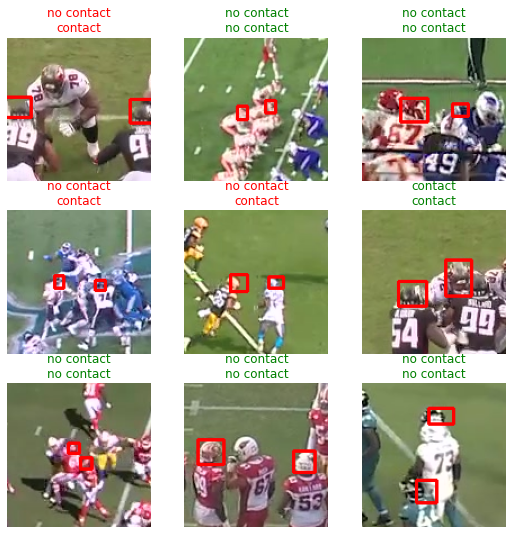

In [13]:
if CFG.train:
    cpu = not torch.cuda.is_available()
    learn = load_learner('nflutils/model-3.pkl', cpu=cpu)
    learn.dls = dls
    learn.show_results()

# Validation

In [14]:
if CFG.valid:
    cpu = not torch.cuda.is_available()
    learn = load_learner('nflutils/model-3.pkl', cpu=cpu)
    
    frames_df = get_frames_df(df_combo_with_helmets, kf_dict, split=0, frames_path=CFG.frames_path, sample_every_n_frame=1, sample_train=0.01, sample_val=0.1)
    val_df = frames_df.query('is_valid').copy()
    
    validate_model(learn, df_combo, val_df, thresh=0.3) 

Baseline 0.5355998345848321
Model 0.3855873779012265


# Inference

In [ ]:
if CFG.infer:
    cpu = not torch.cuda.is_available()
    learn = load_learner(CFG.utils_path+'/'+CFG.model_name, cpu=cpu)

In [ ]:
if CFG.infer:
    ss = expand_contact_id(ss)
    ss_dist = compute_distance(ss, te_tracking, merge_col="step")
    ss_dist_with_helmets = merge_tracking_and_helmets(ss_dist.query('distance <= 1.6'), te_helmets)
    ss_dist_with_helmets = calc_two_players_helmets_center(ss_dist_with_helmets)
    ss_dist_with_helmets = ss_dist_with_helmets.query("view != 'Endzone2'")
    ss_dist_with_helmets = ss_dist_with_helmets[~ss_dist_with_helmets.view.isna()]
    ss_dist_with_helmets = ss_dist_with_helmets[~ss_dist_with_helmets.left_2.isna()]
    ss_dist_with_helmets = ss_dist_with_helmets.astype({'frame': 'int'})

In [ ]:
if CFG.infer:
    !mkdir -p test
    !chmod 777 test
    
    g_paths = !ls /kaggle/input/nfl-player-contact-detection/test/$g
    for g_path in tqdm(g_paths):
        # Need to account for different 
        game_play = g_path.split('/')[-1].split('/')[-1]
        if "Endzone2" not in game_play:
            !ffmpeg -i "/kaggle/input/nfl-player-contact-detection/test/$g_path" -q:v 2 -f image2 test/"$game_play"_%04d.jpg -hide_banner -loglevel error

In [ ]:
if CFG.infer:
    ss_dist_with_helmets['path'] = ss_dist_with_helmets.apply(lambda x: get_frame_path(x, '/kaggle/working/test', 'test'), axis=1)
    ss_dist_with_helmets = add_contact_id(ss_dist_with_helmets)
    display(ss_dist_with_helmets.head())

In [ ]:
if CFG.infer:
    test_dl = learn.dls.test_dl(ss_dist_with_helmets)
    preds, _ = learn.get_preds(dl=test_dl) 
    
    ss_dist_with_helmets.loc[:, 'contact_pred'] = preds.cpu().detach().numpy()[:, 1]
    ss_dist_with_helmets = ss_dist_with_helmets.groupby('contact_id', as_index=False).agg({'contact_pred': 'mean', 'distance': 'first'})

In [ ]:
if CFG.infer:
    sub = pd.read_csv('/kaggle/input/nfl-player-contact-detection/sample_submission.csv')

    sub = sub.drop("contact", axis=1).merge(ss_dist_with_helmets[['contact_id', 'contact_pred', 'distance']], how='left', on='contact_id')
    
    sub['contact'] = np.where(sub['contact_pred'].isna(),
                              sub['distance'] <= 1, 
                              sub['contact_pred'] > CFG.thresh).astype(int)
    
    sub[["contact_id", "contact"]].to_csv("submission.csv", index=False)
    sub.head()